# * TOL Performance

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
as_week = 2023024
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tol_rev_cd_list = ['TB3R000100', 'TB3R000101', 'TB3R000102']
tol_sub_cd_list = ['TB3S000100', 'TB3S000101', 'TB3S000400', 'TB3S000500', 'TSER13100']# Include "TOL Churn Subs"
tol_all_cd_list = tol_rev_cd_list + tol_sub_cd_list

In [3]:
df.shape

(59309, 22)

In [4]:
# ''' Find Metric '''

# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
# df_metric = pd.concat([df_agg_s, df_agg_n])
# # df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TOL"]#.reset_index()
# # df_tmp = df_tmp[df_tmp['CENTER']=="Sales & Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('TOL_Metric.xlsx', index=False)
# df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD'])

## Data Preporation

In [5]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [6]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(tol_all_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
50756,20230620,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,9.779204e+08,NaN,1.039215e+09,2023-06-23 09:51:04,June,25,20
50757,20230621,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,9.779204e+08,NaN,1.039215e+09,2023-06-23 09:51:04,June,25,21
50758,20230622,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,9.779204e+08,NaN,1.039215e+09,2023-06-23 09:51:04,June,25,22


In [7]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

In [8]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [9]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

# df_rev_day.to_excel('df_rev_day.xlsx', index=False)
df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
909,50756,TB3R000100,TOL Revenue,20230620,2023025,202306,20232,2023,June,20,...,9.779204e+08,NaN,1.039215e+09,NaN,NaN,NaN,NaN,1.477397e+08,NaN,NaN
910,50757,TB3R000100,TOL Revenue,20230621,2023025,202306,20232,2023,June,21,...,9.779204e+08,NaN,1.039215e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,50758,TB3R000100,TOL Revenue,20230622,2023025,202306,20232,2023,June,22,...,9.779204e+08,NaN,1.039215e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
''' Fix Columns Dict '''

cols_dict = {'TOL Revenue':'TOTAL', 'TOL New Revenue':'NEW', 'TOL Exisitng Revenue':'EXIST', 
             'TOL Connected Subs':'CON_SUB', 'TOL Registration Subs':'REG_SUB', 'TOL Net Add':'NET_ADD', 'TOL Active Subs':'ACTV_SUB', 'TOL Churn Subs':'CHRN_SUB'}

In [11]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
111           20230620   2023025     202306      20232      2023     June   
112           20230621   2023025     202306      20232      2023     June   
113           20230622   2023025     202306      20232      2023     June   

            DAY_LABEL        ACT                   ...    DIFF        \
METRIC_NAME             ACTV_SUB CHRN_SUB CON_SUB  ... REG_SUB TOTAL   
111                20  3048413.0      NaN  1571.0  ...   -34.0   NaN   
112                21  3046242.0      NaN  1531.0  ...   282.0   NaN   
113                22  3046242.0      NaN  1525.0  ...  -259.0   NaN   

                 %DOD                                                       
METRIC_NAME  ACTV_SUB CHRN_SUB   CON_SUB EXIST NET_ADD NEW   REG_SUB TOTAL  
111          0.000000      NaN -0.072609   NaN     NaN NaN -0.016618   NaN  
112         -0.000712      NaN -0.025461   NaN     NaN NaN  0.140159   NaN  
113          0.000000      NaN -0.003919   NaN     NaN NaN -0.112903   NaN  

[3 rows x 63 columns]

## ** Yearly **

### YR : Aggregation

In [12]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = np.where(df_rev_yr['METRIC_NAME']=='TOL Churn Subs', -((df_rev_yr['ACT']/df_rev_yr['TGT'])-1), df_rev_yr['ACT']/df_rev_yr['TGT'])
df_rev_yr['GAP'] = df_rev_yr['ACT'] - df_rev_yr['TGT']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB3R000100,TOL Revenue,2023,S,5.057140e+09,5.559712e+09,0.909605,-5.025715e+08,NaN,NaN,NaN
1,TB3R000101,TOL New Revenue,2023,S,4.097848e+08,6.125274e+08,0.669007,-2.027426e+08,NaN,NaN,NaN
2,TB3R000102,TOL Exisitng Revenue,2023,S,4.647355e+09,4.949440e+09,0.938966,-3.020848e+08,NaN,NaN,NaN
3,TB3S000100,TOL Connected Subs,2023,S,2.039000e+05,2.615491e+05,0.779586,-5.764908e+04,NaN,NaN,NaN
4,TB3S000101,TOL Registration Subs,2023,S,2.511690e+05,0.000000e+00,inf,2.511690e+05,NaN,NaN,NaN
5,TB3S000400,TOL Net Add,2023,S,3.111100e+04,1.524061e+05,0.204132,-1.212951e+05,NaN,NaN,NaN
6,TSER13100,TOL Churn Subs,2023,S,1.664680e+05,1.010820e+05,-0.646861,6.538600e+04,NaN,NaN,NaN
49047,TB3S000500,TOL Active Subs,2023,N,3.046242e+06,3.194012e+06,0.953735,-1.477695e+05,NaN,NaN,NaN


In [13]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR        ACT                                             \
METRIC_NAME             ACTV_SUB  CHRN_SUB   CON_SUB         EXIST  NET_ADD   
0                2023  3046242.0  166468.0  203900.0  4.647355e+09  31111.0   

                                                         TGT  ...    DIFF  \
METRIC_NAME           NEW   REG_SUB         TOTAL   ACTV_SUB  ... REG_SUB   
0            4.097848e+08  251169.0  5.057140e+09  3194011.5  ...     NaN   

                      %YOY                                                   
METRIC_NAME TOTAL ACTV_SUB CHRN_SUB CON_SUB EXIST NET_ADD NEW REG_SUB TOTAL  
0             NaN      NaN      NaN     NaN   NaN     NaN NaN     NaN   NaN  

[1 rows x 57 columns]

In [14]:
''' YTD Values '''

day_cnt_curr_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())
day_cnt_last_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_yr_rev = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['TOTAL'].sum()
last_yr_rev_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW'].sum()
last_yr_rev_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['EXIST'].sum()
last_yr_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['ACTV_SUB'].sum()
last_yr_con_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CON_SUB'].sum()
last_yr_reg_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['REG_SUB'].sum()
last_yr_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CHRN_SUB'].sum()
last_yr_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
ytd_rev = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_rev / ytd_tgt
ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy = (ytd_rev / ytd_last_rev) - 1
ytd_gap = ytd_rev - ytd_last_rev

''' NEW : Values '''
ytd_rev_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW'].sum()
ytd_tgt_new = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW'].sum()
ytd_achv_new = ytd_rev_new / ytd_tgt_new
ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new = (ytd_rev_new / ytd_last_rev_new) - 1
ytd_gap_new = ytd_rev_new - ytd_last_rev_new

''' EXIST : Values '''
ytd_rev_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['EXIST'].sum()
ytd_tgt_exist = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['EXIST'].sum()
ytd_achv_exist = ytd_rev_exist / ytd_tgt_exist
ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_exist = (ytd_rev_exist / ytd_last_rev_exist) - 1
ytd_gap_exist = ytd_rev_exist - ytd_last_rev_exist

''' ACTV_SUB : Values '''
ytd_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
ytd_tgt_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
ytd_achv_actv_sub = ytd_actv_sub / ytd_tgt_actv_sub
ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_actv_sub = (ytd_actv_sub / ytd_last_actv_sub) - 1
ytd_gap_actv_sub = ytd_actv_sub - ytd_last_actv_sub

''' CON_SUB : Values '''
ytd_con_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CON_SUB'].sum()
ytd_tgt_con_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CON_SUB'].sum()
ytd_achv_con_sub = ytd_con_sub / ytd_tgt_con_sub
ytd_last_con_sub = (last_yr_con_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_con_sub = (ytd_con_sub / ytd_last_con_sub) - 1
ytd_gap_con_sub = ytd_con_sub - ytd_last_con_sub

''' REG_SUB : Values '''
ytd_reg_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['REG_SUB'].sum()
ytd_tgt_reg_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['REG_SUB'].sum()
ytd_achv_reg_sub = ytd_reg_sub / ytd_tgt_reg_sub
ytd_last_reg_sub = (last_yr_reg_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_reg_sub = (ytd_reg_sub / ytd_last_reg_sub) - 1
ytd_gap_reg_sub = ytd_reg_sub - ytd_last_reg_sub

''' CHRN_SUB : Values '''
ytd_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CHRN_SUB'].sum()
ytd_tgt_chrn_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CHRN_SUB'].sum()
ytd_achv_chrn_sub = -((ytd_chrn_sub / ytd_tgt_chrn_sub) - 1)
ytd_last_chrn_sub = (last_yr_chrn_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_chrn_sub = (ytd_chrn_sub / ytd_last_chrn_sub) - 1
ytd_gap_chrn_sub = ytd_chrn_sub - ytd_last_chrn_sub

''' NET_ADD : Values '''
ytd_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NET_ADD'].sum()
ytd_tgt_net_add = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NET_ADD'].sum()
ytd_achv_net_add = ytd_net_add / ytd_tgt_net_add
ytd_last_net_add = (last_yr_net_add / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_net_add = (ytd_net_add / ytd_last_net_add) - 1
ytd_gap_net_add = ytd_net_add - ytd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1996660299.py:20: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1996660299.py:28: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1996660299.py:36: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1996660299.py:44: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1996660299.py:52: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_con_sub = (last_yr_con_sub / day_cnt_last_yr) * day

In [15]:
''' YTD BarH Dataframe'''

df_bar_h_ytd = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_ytd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_ytd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_ytd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_ytd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_ytd = df_bar_h_ytd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_ytd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,31111.0,gold,4
2,CHRN_SUB,166468.0,lightcoral,3
0,CON_SUB,203900.0,limegreen,2
1,REG_SUB,251169.0,royalblue,1


In [16]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' TOTAL : Values '''
y_yr_act = df_rev_yr_agg['ACT']['TOTAL']
y_yr_tgt = df_rev_yr_agg['TGT']['TOTAL']
y_yr_achv = df_rev_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_rev_yr_agg['GAP']['TOTAL']
y_yr_diff = df_rev_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_rev_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT']['NEW']
y_yr_tgt_new = df_rev_yr_agg['TGT']['NEW']
y_yr_achv_new = df_rev_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_rev_yr_agg['GAP']['NEW']
y_yr_diff_new = df_rev_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_rev_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT']['EXIST']
y_yr_tgt_exist = df_rev_yr_agg['TGT']['EXIST']
y_yr_achv_exist = df_rev_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_rev_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_rev_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_rev_yr_agg['%YOY']['EXIST']

''' ACTV_SUB : Values '''
y_yr_act_actv_sub = df_rev_yr_agg['ACT']['ACTV_SUB']
y_yr_tgt_actv_sub = df_rev_yr_agg['TGT']['ACTV_SUB']
y_yr_achv_actv_sub = df_rev_yr_agg['%ACHV']['ACTV_SUB']
y_yr_gap_actv_sub = df_rev_yr_agg['GAP']['ACTV_SUB']
y_yr_diff_actv_sub = df_rev_yr_agg['DIFF']['ACTV_SUB']
y_yr_last_act_actv_sub = df_rev_yr_agg['LAST_ACT']['ACTV_SUB']
y_yr_yoy_actv_sub = df_rev_yr_agg['%YOY']['ACTV_SUB']

''' CON_SUB : Values '''
y_yr_act_con_sub = df_rev_yr_agg['ACT']['CON_SUB']
y_yr_tgt_con_sub = df_rev_yr_agg['TGT']['CON_SUB']
y_yr_achv_con_sub = df_rev_yr_agg['%ACHV']['CON_SUB']
y_yr_gap_con_sub = df_rev_yr_agg['GAP']['CON_SUB']
y_yr_diff_con_sub = df_rev_yr_agg['DIFF']['CON_SUB']
y_yr_last_act_con_sub = df_rev_yr_agg['LAST_ACT']['CON_SUB']
y_yr_yoy_con_sub = df_rev_yr_agg['%YOY']['CON_SUB']

''' REG_SUB : Values '''
y_yr_act_reg_sub = df_rev_yr_agg['ACT']['REG_SUB']
y_yr_tgt_reg_sub = df_rev_yr_agg['TGT']['REG_SUB']
y_yr_achv_reg_sub = df_rev_yr_agg['%ACHV']['REG_SUB']
y_yr_gap_reg_sub = df_rev_yr_agg['GAP']['REG_SUB']
y_yr_diff_reg_sub = df_rev_yr_agg['DIFF']['REG_SUB']
y_yr_last_act_reg_sub = df_rev_yr_agg['LAST_ACT']['REG_SUB']
y_yr_yoy_reg_sub = df_rev_yr_agg['%YOY']['REG_SUB']

''' CHRN_SUB : Values '''
y_yr_act_chrn_sub = df_rev_yr_agg['ACT']['CHRN_SUB']
y_yr_tgt_chrn_sub = df_rev_yr_agg['TGT']['CHRN_SUB']
y_yr_achv_chrn_sub = df_rev_yr_agg['%ACHV']['CHRN_SUB']
y_yr_gap_chrn_sub = df_rev_yr_agg['GAP']['CHRN_SUB']
y_yr_diff_chrn_sub = df_rev_yr_agg['DIFF']['CHRN_SUB']
y_yr_last_act_chrn_sub = df_rev_yr_agg['LAST_ACT']['CHRN_SUB']
y_yr_yoy_chrn_sub = df_rev_yr_agg['%YOY']['CHRN_SUB']

''' NET_ADD : Values '''
y_yr_act_net_add = df_rev_yr_agg['ACT']['NET_ADD']
y_yr_tgt_net_add = df_rev_yr_agg['TGT']['NET_ADD']
y_yr_achv_net_add = df_rev_yr_agg['%ACHV']['NET_ADD']
y_yr_gap_net_add = df_rev_yr_agg['GAP']['NET_ADD']
y_yr_diff_net_add = df_rev_yr_agg['DIFF']['NET_ADD']
y_yr_last_act_net_add = df_rev_yr_agg['LAST_ACT']['NET_ADD']
y_yr_yoy_net_add = df_rev_yr_agg['%YOY']['NET_ADD']

### YR : TOL Revenue Summary

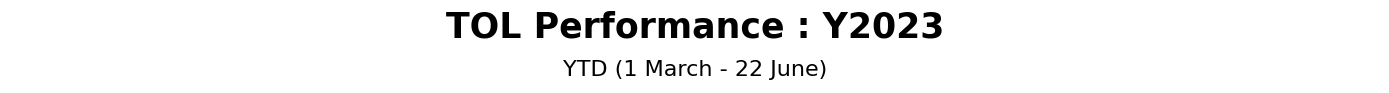

In [17]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TOL Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

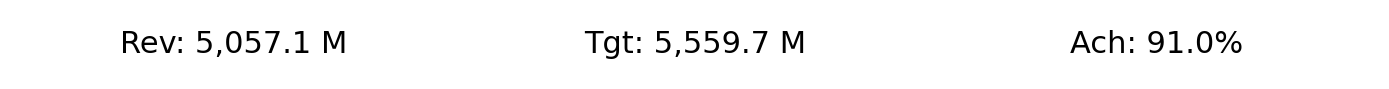

In [18]:
''' YTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(ytd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

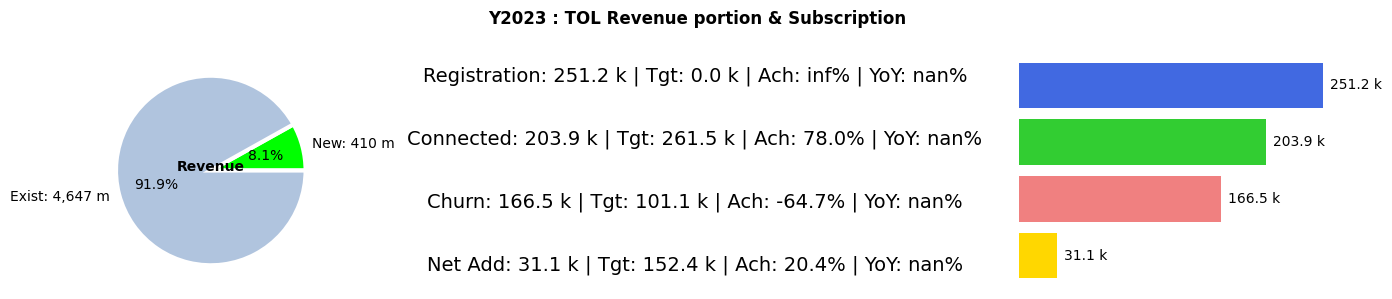

In [19]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Y{curr_yr} : TOL Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(ytd_rev_new.sum()), unit_mb(ytd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(ytd_reg_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_reg_sub),',.1f')} k | Ach: {format(ytd_achv_reg_sub,',.1%')} | YoY: {format(ytd_yoy_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(ytd_con_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_con_sub),',.1f')} k | Ach: {format(ytd_achv_con_sub,',.1%')} | YoY: {format(ytd_yoy_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(ytd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_chrn_sub),',.1f')} k | Ach: {format(ytd_achv_chrn_sub,',.1%')} | YoY: {format(ytd_yoy_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(ytd_net_add),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_net_add),',.1f')} k | Ach: {format(ytd_achv_net_add,',.1%')} | YoY: {format(ytd_yoy_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_ytd['METRIC_NAME'], width=unit_k(df_bar_h_ytd['VALUES']), color=df_bar_h_ytd['COLOR'])
# ax6.bar_label(bars, label_type='edge', padding=-45, fontweight='bold', fmt='%.1f k', color='white')
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

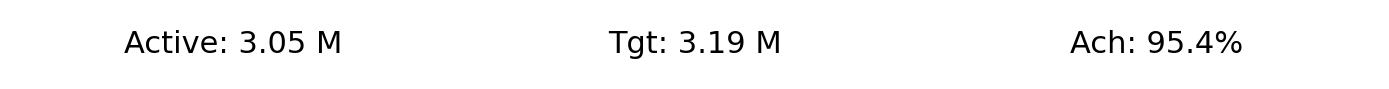

In [20]:
''' YTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(ytd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy_actv_sub,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [21]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = np.where(df_rev_mth['METRIC_NAME']=='TOL Churn Subs', -((df_rev_mth['ACT']/df_rev_mth['TGT'])-1), df_rev_mth['ACT']/df_rev_mth['TGT'])
df_rev_mth['GAP'] = df_rev_mth['ACT'] - df_rev_mth['TGT']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
48995,TB3S000500,TOL Active Subs,202304,April,N,3057351.0,3124065.0,0.978645,-66714.0,3059512.0,-2161.0,-0.000706
49026,TB3S000500,TOL Active Subs,202305,May,N,3051428.0,3165210.0,0.964052,-113782.0,3057351.0,-5923.0,-0.001937
49047,TB3S000500,TOL Active Subs,202306,June,N,3046242.0,3194011.5,0.953735,-147769.5,3051428.0,-5186.0,-0.001700


In [22]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC        ACT                                  \
METRIC_NAME                       ACTV_SUB CHRN_SUB  CON_SUB         EXIST   
1               202304    April  3057351.0  46117.0  52240.0  1.301262e+09   
2               202305      May  3051428.0  44845.0  55821.0  1.151590e+09   
3               202306     June  3046242.0  28261.0  35131.0  8.729361e+08   

                                                           ...     DIFF  \
METRIC_NAME  NET_ADD           NEW  REG_SUB         TOTAL  ...  REG_SUB   
1             6123.0  1.042535e+08  65935.0  1.405516e+09  ...  -8594.0   
2            10976.0  1.207113e+08  67936.0  1.272301e+09  ...   2001.0   
3              549.0  1.049843e+08  42769.0  9.779204e+08  ... -25167.0   

                               %MOM                                          \
METRIC_NAME         TOTAL  ACTV_SUB  CHRN_SUB   CON_SUB     EXIST   NET_ADD   
1            4.112948e+06 -0.000706 -0.023876 -0.139487 -0.015364 -0.545198   
2           -1.332144e+08 -0.001937 -0.027582  0.068549 -0.115021  0.792585   
3           -2.943809e+08 -0.001700 -0.369807 -0.370649 -0.241973 -0.949982   

                                           
METRIC_NAME       NEW   REG_SUB     TOTAL  
1            0.305852 -0.115311  0.002935  
2            0.157863  0.030348 -0.094780  
3           -0.130286 -0.370452 -0.231377  

[3 rows x 58 columns]

In [23]:
''' MTD Values '''

day_cnt_curr_mth = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TM_KEY_DAY'].unique())
day_cnt_last_mth = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_mth_rev = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['TOTAL'].sum()
last_mth_rev_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW'].sum()
last_mth_rev_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['EXIST'].sum()
last_mth_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['ACTV_SUB'].sum()
last_mth_con_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CON_SUB'].sum()
last_mth_reg_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['REG_SUB'].sum()
last_mth_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CHRN_SUB'].sum()
last_mth_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
mtd_rev = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_rev / mtd_tgt
mtd_last_rev = (last_mth_rev / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom = (mtd_rev / mtd_last_rev) - 1
mtd_gap = mtd_rev - mtd_last_rev

''' NEW : Values '''
mtd_rev_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW'].sum()
mtd_tgt_new = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW'].sum()
mtd_achv_new = mtd_rev_new / mtd_tgt_new
mtd_last_rev_new = (last_mth_rev_new / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new = (mtd_rev_new / mtd_last_rev_new) - 1
mtd_gap_new = mtd_rev_new - mtd_last_rev_new

''' EXIST : Values '''
mtd_rev_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['EXIST'].sum()
mtd_tgt_exist = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['EXIST'].sum()
mtd_achv_exist = mtd_rev_exist / mtd_tgt_exist
mtd_last_rev_exist = (last_mth_rev_exist / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_exist = (mtd_rev_exist / mtd_last_rev_exist) - 1
mtd_gap_exist = mtd_rev_exist - mtd_last_rev_exist

''' ACTV_SUB : Values '''
mtd_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['ACTV_SUB'].sum()
mtd_tgt_actv_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['ACTV_SUB'].sum()
mtd_achv_actv_sub = mtd_actv_sub / mtd_tgt_actv_sub
mtd_last_actv_sub = (last_mth_actv_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_actv_sub = (mtd_actv_sub / mtd_last_actv_sub) - 1
mtd_gap_actv_sub = mtd_actv_sub - mtd_last_actv_sub

''' CON_SUB : Values '''
mtd_con_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CON_SUB'].sum()
mtd_tgt_con_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CON_SUB'].sum()
mtd_achv_con_sub = mtd_con_sub / mtd_tgt_con_sub
mtd_last_con_sub = (last_mth_con_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_con_sub = (mtd_con_sub / mtd_last_con_sub) - 1
mtd_gap_con_sub = mtd_con_sub - mtd_last_con_sub

''' REG_SUB : Values '''
mtd_reg_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['REG_SUB'].sum()
mtd_tgt_reg_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['REG_SUB'].sum()
mtd_achv_reg_sub = mtd_reg_sub / mtd_tgt_reg_sub
mtd_last_reg_sub = (last_mth_reg_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_reg_sub = (mtd_reg_sub / mtd_last_reg_sub) - 1
mtd_gap_reg_sub = mtd_reg_sub - mtd_last_reg_sub

''' CHRN_SUB : Values '''
mtd_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CHRN_SUB'].sum()
mtd_tgt_chrn_sub = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CHRN_SUB'].sum()
mtd_achv_chrn_sub = -((mtd_chrn_sub / mtd_tgt_chrn_sub) - 1)
mtd_last_chrn_sub = (last_mth_chrn_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_chrn_sub = (mtd_chrn_sub / mtd_last_chrn_sub) - 1
mtd_gap_chrn_sub = mtd_chrn_sub - mtd_last_chrn_sub

''' NET_ADD : Values '''
mtd_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NET_ADD'].sum()
mtd_tgt_net_add = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NET_ADD'].sum()
mtd_achv_net_add = mtd_net_add / mtd_tgt_net_add
mtd_last_net_add = (last_mth_net_add / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_net_add = (mtd_net_add / mtd_last_net_add) - 1
mtd_gap_net_add = mtd_net_add - mtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\2802582081.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_reg_sub = mtd_reg_sub / mtd_tgt_reg_sub


In [24]:
''' MTD BarH Dataframe'''

df_bar_h_mtd = df_rev_mth_agg[df_rev_mth_agg['TM_KEY_MTH']==curr_mth]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_mtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_mtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_mtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_mtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_mtd = df_bar_h_mtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_mtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,549.0,gold,4
2,CHRN_SUB,28261.0,lightcoral,3
0,CON_SUB,35131.0,limegreen,2
1,REG_SUB,42769.0,royalblue,1


In [25]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' TOTAL : Values '''
y_mth_act = df_rev_mth_agg['ACT']['TOTAL']
y_mth_tgt = df_rev_mth_agg['TGT']['TOTAL']
y_mth_achv = df_rev_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_rev_mth_agg['GAP']['TOTAL']
y_mth_diff = df_rev_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_rev_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT']['NEW']
y_mth_tgt_new = df_rev_mth_agg['TGT']['NEW']
y_mth_achv_new = df_rev_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_rev_mth_agg['GAP']['NEW']
y_mth_diff_new = df_rev_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_rev_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT']['EXIST']
y_mth_tgt_exist = df_rev_mth_agg['TGT']['EXIST']
y_mth_achv_exist = df_rev_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_rev_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_rev_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_rev_mth_agg['%MOM']['EXIST']

''' ACTV_SUB : Values '''
y_mth_act_actv_sub = df_rev_mth_agg['ACT']['ACTV_SUB']
y_mth_tgt_actv_sub = df_rev_mth_agg['TGT']['ACTV_SUB']
y_mth_achv_actv_sub = df_rev_mth_agg['%ACHV']['ACTV_SUB']
y_mth_gap_actv_sub = df_rev_mth_agg['GAP']['ACTV_SUB']
y_mth_diff_actv_sub = df_rev_mth_agg['DIFF']['ACTV_SUB']
y_mth_last_act_actv_sub = df_rev_mth_agg['LAST_ACT']['ACTV_SUB']
y_mth_mom_actv_sub = df_rev_mth_agg['%MOM']['ACTV_SUB']

''' CON_SUB : Values '''
y_mth_act_con_sub = df_rev_mth_agg['ACT']['CON_SUB']
y_mth_tgt_con_sub = df_rev_mth_agg['TGT']['CON_SUB']
y_mth_achv_con_sub = df_rev_mth_agg['%ACHV']['CON_SUB']
y_mth_gap_con_sub = df_rev_mth_agg['GAP']['CON_SUB']
y_mth_diff_con_sub = df_rev_mth_agg['DIFF']['CON_SUB']
y_mth_last_act_con_sub = df_rev_mth_agg['LAST_ACT']['CON_SUB']
y_mth_mom_con_sub = df_rev_mth_agg['%MOM']['CON_SUB']

''' REG_SUB : Values '''
y_mth_act_reg_sub = df_rev_mth_agg['ACT']['REG_SUB']
y_mth_tgt_reg_sub = df_rev_mth_agg['TGT']['REG_SUB']
y_mth_achv_reg_sub = df_rev_mth_agg['%ACHV']['REG_SUB']
y_mth_gap_reg_sub = df_rev_mth_agg['GAP']['REG_SUB']
y_mth_diff_reg_sub = df_rev_mth_agg['DIFF']['REG_SUB']
y_mth_last_act_reg_sub = df_rev_mth_agg['LAST_ACT']['REG_SUB']
y_mth_mom_reg_sub = df_rev_mth_agg['%MOM']['REG_SUB']

''' CHRN_SUB : Values '''
y_mth_act_chrn_sub = df_rev_mth_agg['ACT']['CHRN_SUB']
y_mth_tgt_chrn_sub = df_rev_mth_agg['TGT']['CHRN_SUB']
y_mth_achv_chrn_sub = df_rev_mth_agg['%ACHV']['CHRN_SUB']
y_mth_gap_chrn_sub = df_rev_mth_agg['GAP']['CHRN_SUB']
y_mth_diff_chrn_sub = df_rev_mth_agg['DIFF']['CHRN_SUB']
y_mth_last_act_chrn_sub = df_rev_mth_agg['LAST_ACT']['CHRN_SUB']
y_mth_mom_chrn_sub = df_rev_mth_agg['%MOM']['CHRN_SUB']

''' NET_ADD : Values '''
y_mth_act_net_add = df_rev_mth_agg['ACT']['NET_ADD']
y_mth_tgt_net_add = df_rev_mth_agg['TGT']['NET_ADD']
y_mth_achv_net_add = df_rev_mth_agg['%ACHV']['NET_ADD']
y_mth_gap_net_add = df_rev_mth_agg['GAP']['NET_ADD']
y_mth_diff_net_add = df_rev_mth_agg['DIFF']['NET_ADD']
y_mth_last_act_net_add = df_rev_mth_agg['LAST_ACT']['NET_ADD']
y_mth_mom_net_add = df_rev_mth_agg['%MOM']['NET_ADD']

### MTH : TOL Revenue Summary

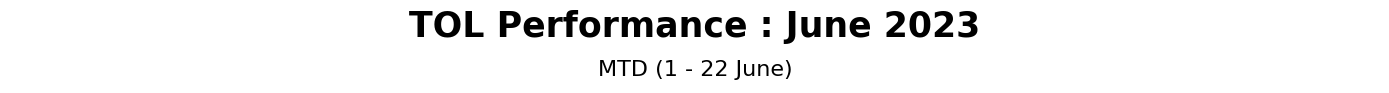

In [26]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TOL Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

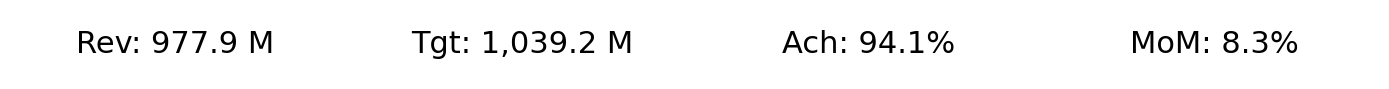

In [27]:
''' MTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(mtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

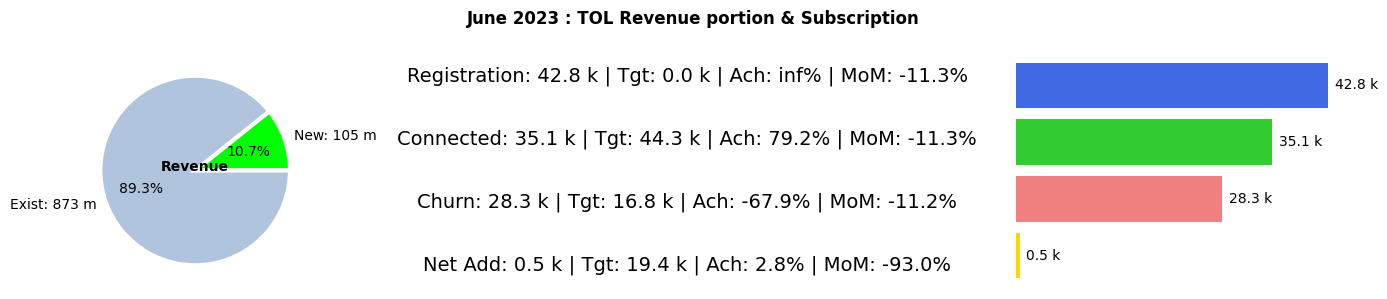

In [28]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'{curr_mth_desc} {curr_yr} : TOL Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(mtd_rev_new.sum()), unit_mb(mtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(mtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_reg_sub),',.1f')} k | Ach: {format(mtd_achv_reg_sub,',.1%')} | MoM: {format(mtd_mom_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(mtd_con_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_con_sub),',.1f')} k | Ach: {format(mtd_achv_con_sub,',.1%')} | MoM: {format(mtd_mom_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(mtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_chrn_sub),',.1f')} k | Ach: {format(mtd_achv_chrn_sub,',.1%')} | MoM: {format(mtd_mom_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(mtd_net_add),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_net_add),',.1f')} k | Ach: {format(mtd_achv_net_add,',.1%')} | MoM: {format(mtd_mom_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_mtd['METRIC_NAME'], width=unit_k(df_bar_h_mtd['VALUES']), color=df_bar_h_mtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

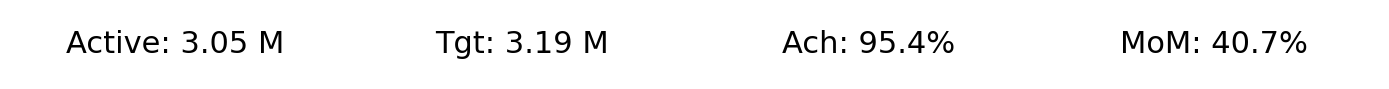

In [29]:
''' MTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(mtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

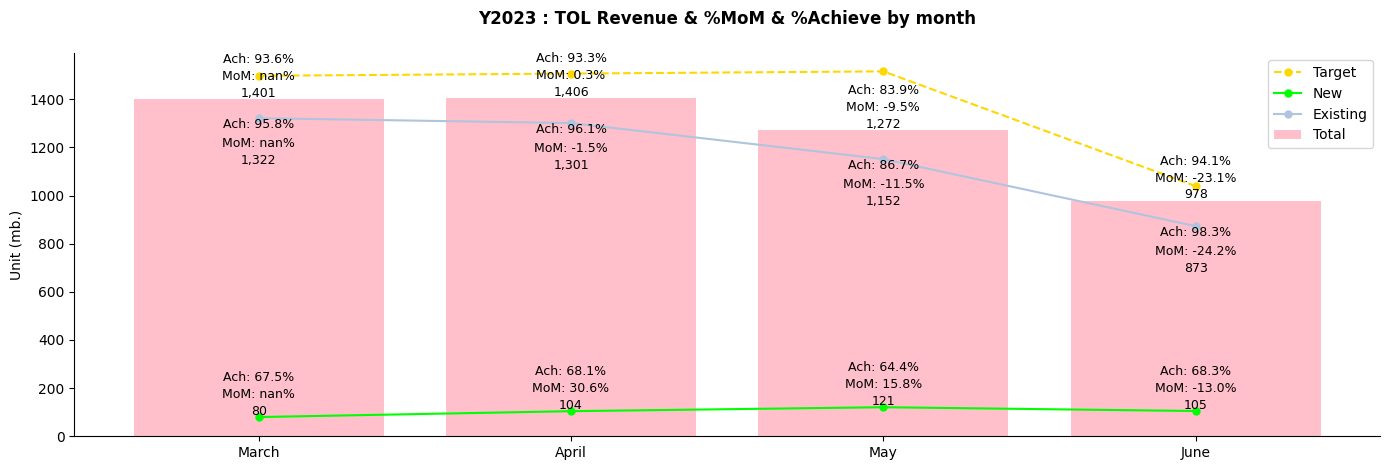

In [30]:
''' Revenue & MoM & Achieve by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TOL Revenue & %MoM & %Achieve by month\n", weight='bold')

plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')

plt.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_mth_axis, unit_mb(y_mth_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+150), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+80), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+10), ha='center', fontsize=9)

    plt.annotate(f"Ach: {format(y_mth_achv_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+150), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+80), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+10), ha='center', fontsize=9)
    
    plt.annotate(f"Ach: {format(y_mth_achv_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i]-10)), ha='center', va='top', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-80), ha='center', va='top', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-150), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

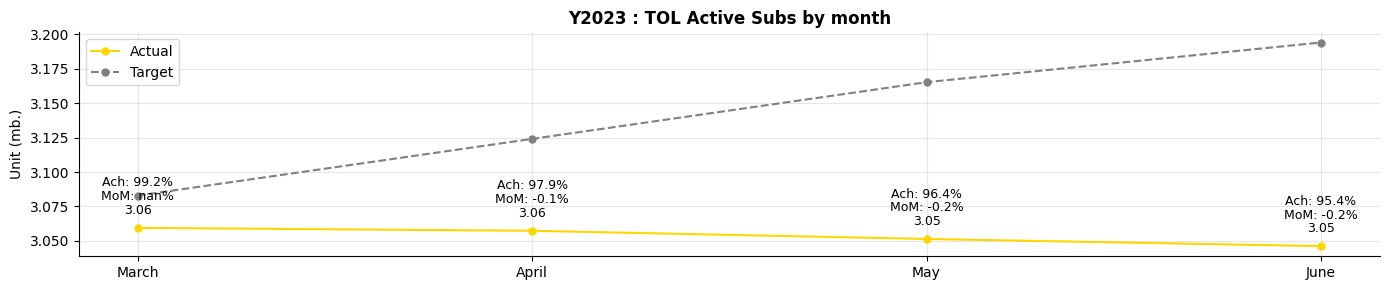

In [31]:
''' Active Subs by month '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : TOL Active Subs by month", weight='bold')

plt.plot(x_mth_axis, unit_mb(y_mth_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.03), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.02), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_actv_sub[i]),',.2f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.01), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

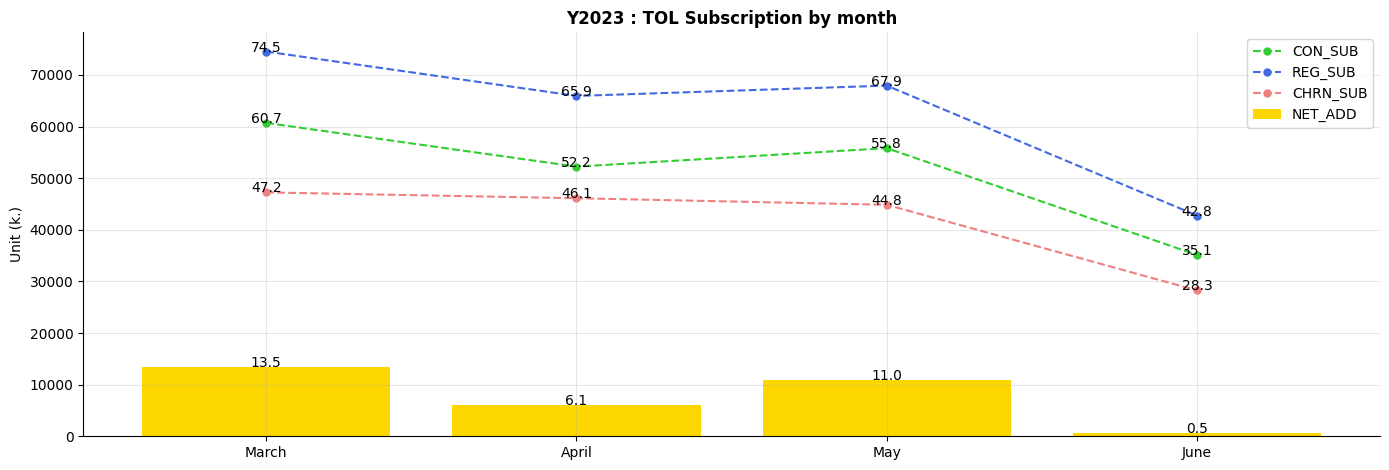

In [32]:
''' Subscription by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TOL Subscription by month", weight='bold')

plt.plot(x_mth_axis, y_mth_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_mth_axis, y_mth_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_mth_axis, y_mth_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_mth_axis, y_mth_act_net_add, label='NET_ADD', color='gold')
for i in x_mth_axis:
    plt.annotate(format(unit_k(y_mth_act_con_sub[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_con_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_reg_sub[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_reg_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_chrn_sub[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_chrn_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_net_add[i]),',.1f'), xy=(x_mth_axis[i], y_mth_act_net_add[i]), ha='center')

plt.ylabel('Unit (k.)')
plt.xticks(x_mth_axis, x_mth)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [33]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' Aggregation '''
df_rev_wk['%ACHV'] = np.where(df_rev_wk['METRIC_NAME']=='TOL Churn Subs', -((df_rev_wk['ACT']/df_rev_wk['TGT'])-1), df_rev_wk['ACT']/df_rev_wk['TGT'])
df_rev_wk['GAP'] = df_rev_wk['ACT'] - df_rev_wk['TGT']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
49037,TB3S000500,TOL Active Subs,2023023,23,N,3050765.0,3180296.5,0.959271,-129531.5,3050888.0,-123.0,-0.000040
49044,TB3S000500,TOL Active Subs,2023024,24,N,3048215.0,3189897.0,0.955584,-141682.0,3050765.0,-2550.0,-0.000836
49047,TB3S000500,TOL Active Subs,2023025,25,N,3046242.0,3194011.5,0.953735,-147769.5,3048215.0,-1973.0,-0.000647


In [34]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL        ACT                                  \
METRIC_NAME                      ACTV_SUB CHRN_SUB  CON_SUB         EXIST   
14            2023023       23  3050765.0   9937.0  11248.0  2.777357e+08   
15            2023024       24  3048215.0  12087.0  10871.0  2.838496e+08   
16            2023025       25  3046242.0      0.0   6321.0  1.329162e+08   

                                                          ...    DIFF  \
METRIC_NAME NET_ADD           NEW  REG_SUB         TOTAL  ... REG_SUB   
14           1311.0  4.216258e+07  12821.0  3.198983e+08  ...  -970.0   
15          -1216.0  3.004306e+07  13419.0  3.138927e+08  ...   598.0   
16              0.0  1.482351e+07   8387.0  1.477397e+08  ... -5032.0   

                               %WOW                                          \
METRIC_NAME         TOTAL  ACTV_SUB  CHRN_SUB   CON_SUB     EXIST   NET_ADD   
14           1.235084e+08 -0.000040 -0.006995 -0.010817  0.556512 -0.038856   
15          -6.005587e+06 -0.000836  0.216363 -0.033517  0.022014 -1.927536   
16          -1.661530e+08 -0.000647 -1.000000 -0.418545 -0.531737 -1.000000   

                                           
METRIC_NAME       NEW   REG_SUB     TOTAL  
14           1.348212 -0.070336  0.628894  
15          -0.287447  0.046642 -0.018773  
16          -0.506591 -0.374991 -0.529331  

[3 rows x 58 columns]

In [35]:
''' WTD Values '''

day_cnt_curr_wk = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].unique())
day_cnt_last_wk = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_wk_rev = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['TOTAL'].sum()
last_wk_rev_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW'].sum()
last_wk_rev_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['EXIST'].sum()
last_wk_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['ACTV_SUB'].sum()
last_wk_con_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CON_SUB'].sum()
last_wk_reg_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['REG_SUB'].sum()
last_wk_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CHRN_SUB'].sum()
last_wk_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
wtd_rev = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['TOTAL'].sum()
wtd_tgt = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['TOTAL'].sum()
wtd_achv = wtd_rev / wtd_tgt
wtd_last_rev = (last_wk_rev / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow = (wtd_rev / wtd_last_rev) - 1
wtd_gap = wtd_rev - wtd_last_rev

''' NEW : Values '''
wtd_rev_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW'].sum()
wtd_tgt_new = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW'].sum()
wtd_achv_new = wtd_rev_new / wtd_tgt_new
wtd_last_rev_new = (last_wk_rev_new / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new = (wtd_rev_new / wtd_last_rev_new) - 1
wtd_gap_new = wtd_rev_new - wtd_last_rev_new

''' EXIST : Values '''
wtd_rev_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['EXIST'].sum()
wtd_tgt_exist = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['EXIST'].sum()
wtd_achv_exist = wtd_rev_exist / wtd_tgt_exist
wtd_last_rev_exist = (last_wk_rev_exist / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_exist = (wtd_rev_exist / wtd_last_rev_exist) - 1
wtd_gap_exist = wtd_rev_exist - wtd_last_rev_exist

''' ACTV_SUB : Values '''
wtd_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['ACTV_SUB'].sum()
wtd_tgt_actv_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['ACTV_SUB'].sum()
wtd_achv_actv_sub = wtd_actv_sub / wtd_tgt_actv_sub
wtd_last_actv_sub = (last_wk_actv_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_actv_sub = (wtd_actv_sub / wtd_last_actv_sub) - 1
wtd_gap_actv_sub = wtd_actv_sub - wtd_last_actv_sub

''' CON_SUB : Values '''
wtd_con_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CON_SUB'].sum()
wtd_tgt_con_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CON_SUB'].sum()
wtd_achv_con_sub = wtd_con_sub / wtd_tgt_con_sub
wtd_last_con_sub = (last_wk_con_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_con_sub = (wtd_con_sub / wtd_last_con_sub) - 1
wtd_gap_con_sub = wtd_con_sub - wtd_last_con_sub

''' REG_SUB : Values '''
wtd_reg_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['REG_SUB'].sum()
wtd_tgt_reg_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['REG_SUB'].sum()
wtd_achv_reg_sub = wtd_reg_sub / wtd_tgt_reg_sub
wtd_last_reg_sub = (last_wk_reg_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_reg_sub = (wtd_reg_sub / wtd_last_reg_sub) - 1
wtd_gap_reg_sub = wtd_reg_sub - wtd_last_reg_sub

''' CHRN_SUB : Values '''
wtd_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CHRN_SUB'].sum()
wtd_tgt_chrn_sub = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CHRN_SUB'].sum()
wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
wtd_last_chrn_sub = (last_wk_chrn_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_chrn_sub = (wtd_chrn_sub / wtd_last_chrn_sub) - 1
wtd_gap_chrn_sub = wtd_chrn_sub - wtd_last_chrn_sub

''' NET_ADD : Values '''
wtd_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NET_ADD'].sum()
wtd_tgt_net_add = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NET_ADD'].sum()
wtd_achv_net_add = wtd_net_add / wtd_tgt_net_add
wtd_last_net_add = (last_wk_net_add / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_net_add = (wtd_net_add / wtd_last_net_add) - 1
wtd_gap_net_add = wtd_net_add - wtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\514037668.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_reg_sub = wtd_reg_sub / wtd_tgt_reg_sub
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\514037668.py:67: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\514037668.py:75: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv_net_add = wtd_net_add / wtd_tgt_net_add


In [36]:
''' WTD BarH Dataframe'''

df_bar_h_wtd = df_rev_wk_agg[df_rev_wk_agg['TM_KEY_WK']==curr_wk]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_wtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_wtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_wtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_wtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_wtd = df_bar_h_wtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_wtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,0.0,gold,4
2,CHRN_SUB,0.0,lightcoral,3
0,CON_SUB,6321.0,limegreen,2
1,REG_SUB,8387.0,royalblue,1


In [37]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' TOTAL : Values '''
y_wk_act = df_rev_wk_agg['ACT']['TOTAL']
y_wk_tgt = df_rev_wk_agg['TGT']['TOTAL']
y_wk_achv = df_rev_wk_agg['%ACHV']['TOTAL']
y_wk_gap = df_rev_wk_agg['GAP']['TOTAL']
y_wk_diff = df_rev_wk_agg['DIFF']['TOTAL']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']['TOTAL']
y_wk_wow = df_rev_wk_agg['%WOW']['TOTAL']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT']['NEW']
y_wk_tgt_new = df_rev_wk_agg['TGT']['NEW']
y_wk_achv_new = df_rev_wk_agg['%ACHV']['NEW']
y_wk_gap_new = df_rev_wk_agg['GAP']['NEW']
y_wk_diff_new = df_rev_wk_agg['DIFF']['NEW']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT']['NEW']
y_wk_wow_new = df_rev_wk_agg['%WOW']['NEW']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT']['EXIST']
y_wk_tgt_exist = df_rev_wk_agg['TGT']['EXIST']
y_wk_achv_exist = df_rev_wk_agg['%ACHV']['EXIST']
y_wk_gap_exist = df_rev_wk_agg['GAP']['EXIST']
y_wk_diff_exist = df_rev_wk_agg['DIFF']['EXIST']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT']['EXIST']
y_wk_wow_exist = df_rev_wk_agg['%WOW']['EXIST']

''' ACTV_SUB : Values '''
y_wk_act_actv_sub = df_rev_wk_agg['ACT']['ACTV_SUB']
y_wk_tgt_actv_sub = df_rev_wk_agg['TGT']['ACTV_SUB']
y_wk_achv_actv_sub = df_rev_wk_agg['%ACHV']['ACTV_SUB']
y_wk_gap_actv_sub = df_rev_wk_agg['GAP']['ACTV_SUB']
y_wk_diff_actv_sub = df_rev_wk_agg['DIFF']['ACTV_SUB']
y_wk_last_act_actv_sub = df_rev_wk_agg['LAST_ACT']['ACTV_SUB']
y_wk_wow_actv_sub = df_rev_wk_agg['%WOW']['ACTV_SUB']

''' CON_SUB : Values '''
y_wk_act_con_sub = df_rev_wk_agg['ACT']['CON_SUB']
y_wk_tgt_con_sub = df_rev_wk_agg['TGT']['CON_SUB']
y_wk_achv_con_sub = df_rev_wk_agg['%ACHV']['CON_SUB']
y_wk_gap_con_sub = df_rev_wk_agg['GAP']['CON_SUB']
y_wk_diff_con_sub = df_rev_wk_agg['DIFF']['CON_SUB']
y_wk_last_act_con_sub = df_rev_wk_agg['LAST_ACT']['CON_SUB']
y_wk_wow_con_sub = df_rev_wk_agg['%WOW']['CON_SUB']

''' REG_SUB : Values '''
y_wk_act_reg_sub = df_rev_wk_agg['ACT']['REG_SUB']
y_wk_tgt_reg_sub = df_rev_wk_agg['TGT']['REG_SUB']
y_wk_achv_reg_sub = df_rev_wk_agg['%ACHV']['REG_SUB']
y_wk_gap_reg_sub = df_rev_wk_agg['GAP']['REG_SUB']
y_wk_diff_reg_sub = df_rev_wk_agg['DIFF']['REG_SUB']
y_wk_last_act_reg_sub = df_rev_wk_agg['LAST_ACT']['REG_SUB']
y_wk_wow_reg_sub = df_rev_wk_agg['%WOW']['REG_SUB']

''' CHRN_SUB : Values '''
y_wk_act_chrn_sub = df_rev_wk_agg['ACT']['CHRN_SUB']
y_wk_tgt_chrn_sub = df_rev_wk_agg['TGT']['CHRN_SUB']
y_wk_achv_chrn_sub = df_rev_wk_agg['%ACHV']['CHRN_SUB']
y_wk_gap_chrn_sub = df_rev_wk_agg['GAP']['CHRN_SUB']
y_wk_diff_chrn_sub = df_rev_wk_agg['DIFF']['CHRN_SUB']
y_wk_last_act_chrn_sub = df_rev_wk_agg['LAST_ACT']['CHRN_SUB']
y_wk_wow_chrn_sub = df_rev_wk_agg['%WOW']['CHRN_SUB']

''' NET_ADD : Values '''
y_wk_act_net_add = df_rev_wk_agg['ACT']['NET_ADD']
y_wk_tgt_net_add = df_rev_wk_agg['TGT']['NET_ADD']
y_wk_achv_net_add = df_rev_wk_agg['%ACHV']['NET_ADD']
y_wk_gap_net_add = df_rev_wk_agg['GAP']['NET_ADD']
y_wk_diff_net_add = df_rev_wk_agg['DIFF']['NET_ADD']
y_wk_last_act_net_add = df_rev_wk_agg['LAST_ACT']['NET_ADD']
y_wk_wow_net_add = df_rev_wk_agg['%WOW']['NET_ADD']

### WK : Postpaid Revenue Summary

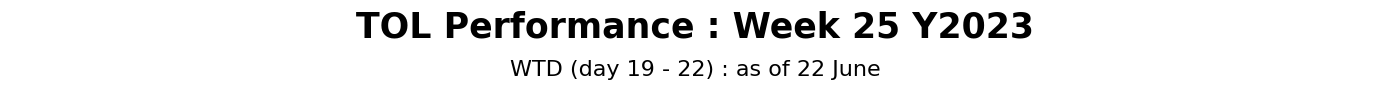

In [38]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"TOL Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

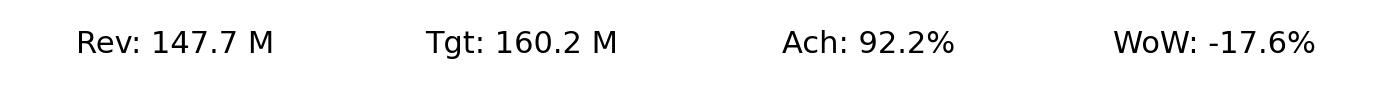

In [39]:
''' WTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(wtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

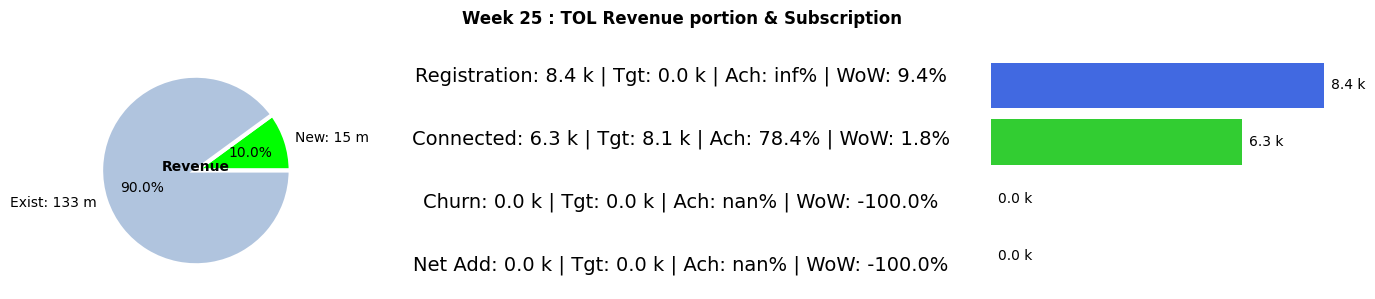

In [40]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Week {curr_wk_label} : TOL Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(wtd_rev_new.sum()), unit_mb(wtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(wtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_reg_sub),',.1f')} k | Ach: {format(wtd_achv_reg_sub,',.1%')} | WoW: {format(wtd_wow_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(wtd_con_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_con_sub),',.1f')} k | Ach: {format(wtd_achv_con_sub,',.1%')} | WoW: {format(wtd_wow_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(wtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_chrn_sub),',.1f')} k | Ach: {format(wtd_achv_chrn_sub,',.1%')} | WoW: {format(wtd_wow_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(wtd_net_add),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_net_add),',.1f')} k | Ach: {format(wtd_achv_net_add,',.1%')} | WoW: {format(wtd_wow_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_wtd['METRIC_NAME'], width=unit_k(df_bar_h_wtd['VALUES']), color=df_bar_h_wtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

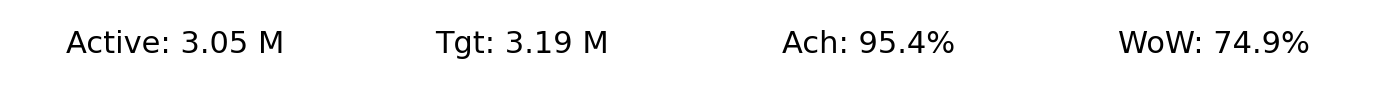

In [41]:
''' WTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(wtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

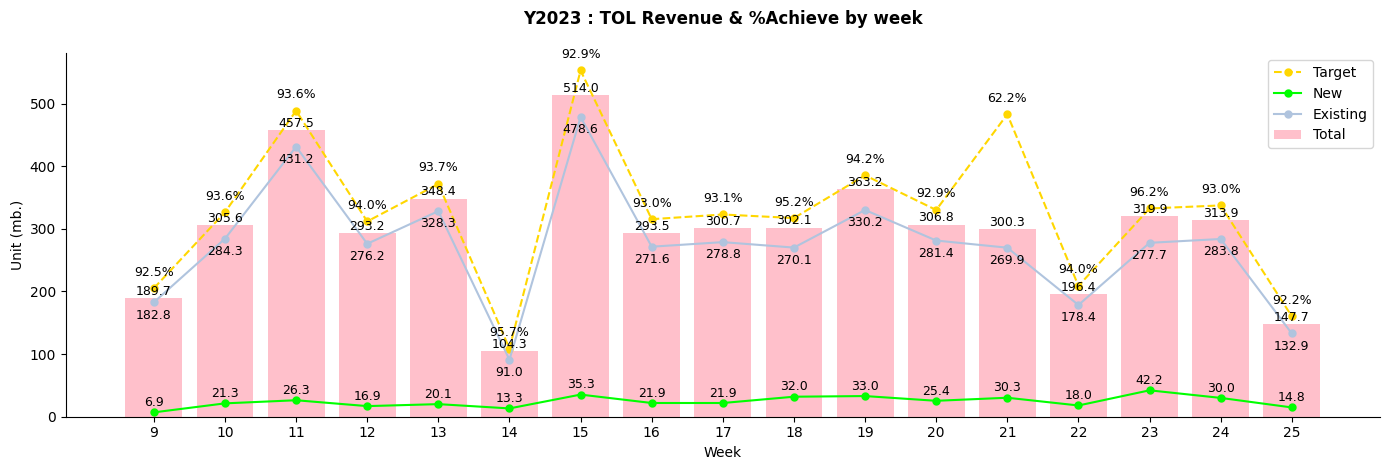

In [56]:
''' Revenue & Achieve by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TOL Revenue & %Achieve by week\n", weight='bold')

plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')

plt.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_wk_axis, unit_mb(y_wk_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_wk_axis:
    plt.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_tgt[i])+20), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_new[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_new[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_exist[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_exist[i])-10), ha='center', va='top', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

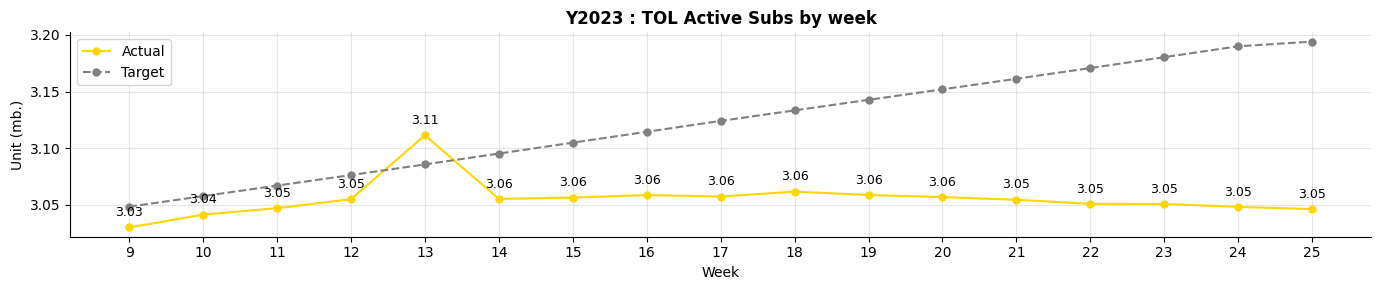

In [43]:
''' Active Subs by week '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : TOL Active Subs by week", weight='bold')

plt.plot(x_wk_axis, unit_mb(y_wk_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act_actv_sub[i]),',.2f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.01), ha='center', fontsize=9)
    # plt.annotate(f"Ach:{format(y_wk_achv_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.03), ha='center', fontsize=8)
    # plt.annotate(f"WoW:{format(y_wk_wow_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.02), ha='center', fontsize=8)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

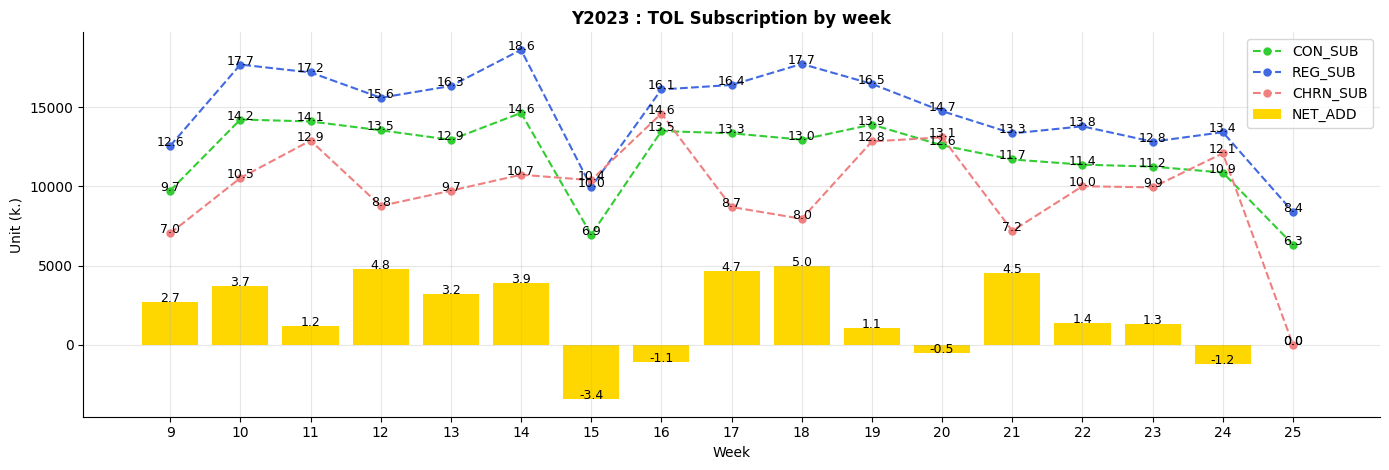

In [59]:
''' Subscription by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : TOL Subscription by week", weight='bold')

plt.plot(x_wk_axis, y_wk_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_wk_axis, y_wk_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_wk_axis, y_wk_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_wk_axis, y_wk_act_net_add, label='NET_ADD', color='gold')
for i in x_wk_axis:
    plt.annotate(format(unit_k(y_wk_act_con_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_con_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_reg_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_reg_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_chrn_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_chrn_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_net_add[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_net_add[i]), ha='center', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (k.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [45]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT']['TOTAL'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [46]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT']['TOTAL'].sum()
last_day_rev_new = df_rev_day_last_day['ACT']['NEW'].sum()
last_day_rev_exist = df_rev_day_last_day['ACT']['EXIST'].sum()
last_day_actv_sub = df_rev_day_last_day['ACT']['ACTV_SUB'].sum()
last_day_con_sub = df_rev_day_last_day['ACT']['CON_SUB'].sum()
last_day_reg_sub = df_rev_day_last_day['ACT']['REG_SUB'].sum()
last_day_chrn_sub = df_rev_day_last_day['ACT']['CHRN_SUB'].sum()
last_day_net_add = df_rev_day_last_day['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT']['TOTAL'].sum()
dtd_tgt = df_rev_day_curr_day['TGT']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_rev_day_curr_day['ACT']['NEW'].sum()
dtd_tgt_new = df_rev_day_curr_day['TGT']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_rev_day_last_day['ACT']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_rev_day_curr_day['ACT']['EXIST'].sum()
dtd_tgt_exist = df_rev_day_curr_day['TGT']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_rev_day_last_day['ACT']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

''' ACTV_SUB : Values '''
dtd_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['ACTV_SUB'].sum()
dtd_tgt_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['ACTV_SUB'].sum()
dtd_achv_actv_sub = dtd_actv_sub / dtd_tgt_actv_sub
dtd_last_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['ACTV_SUB'].sum()
dtd_dod_actv_sub = (dtd_actv_sub / dtd_last_actv_sub) - 1
dtd_gap_actv_sub = dtd_actv_sub - dtd_last_actv_sub

''' CON_SUB : Values '''
dtd_con_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CON_SUB'].sum()
dtd_tgt_con_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CON_SUB'].sum()
dtd_achv_con_sub = dtd_con_sub / dtd_tgt_con_sub
dtd_last_con_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['CON_SUB'].sum()
dtd_dod_con_sub = (dtd_con_sub / dtd_last_con_sub) - 1
dtd_gap_con_sub = dtd_con_sub - dtd_last_con_sub

''' REG_SUB : Values '''
dtd_reg_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['REG_SUB'].sum()
dtd_tgt_reg_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['REG_SUB'].sum()
dtd_achv_reg_sub = dtd_reg_sub / dtd_tgt_reg_sub
dtd_last_reg_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['REG_SUB'].sum()
dtd_dod_reg_sub = (dtd_reg_sub / dtd_last_reg_sub) - 1
dtd_gap_reg_sub = dtd_reg_sub - dtd_last_reg_sub

''' CHRN_SUB : Values '''
dtd_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CHRN_SUB'].sum()
dtd_tgt_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CHRN_SUB'].sum()
dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
dtd_last_chrn_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['CHRN_SUB'].sum()
dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
dtd_gap_chrn_sub = dtd_chrn_sub - dtd_last_chrn_sub

''' NET_ADD : Values '''
dtd_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NET_ADD'].sum()
dtd_tgt_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NET_ADD'].sum()
dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
dtd_last_net_add = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==last_day]['ACT']['NET_ADD'].sum()
dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1
dtd_gap_net_add = dtd_net_add - dtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1822622438.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  dtd_achv_reg_sub = dtd_reg_sub / dtd_tgt_reg_sub
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1822622438.py:64: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1822622438.py:66: RuntimeWarning: invalid value encountered in scalar divide
  dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1822622438.py:72: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21840\1822622438.py:74: RuntimeWarning: invalid value encountered in scalar divide
  dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1


In [47]:
''' DTD BarH Dataframe'''

df_bar_h_dtd = df_rev_day_agg[df_rev_day_agg['TM_KEY_DAY']==curr_day]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_dtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_dtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_dtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_dtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_dtd = df_bar_h_dtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_dtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,NaN,gold,4
2,CHRN_SUB,NaN,lightcoral,3
0,CON_SUB,1525.0,limegreen,2
1,REG_SUB,2035.0,royalblue,1


In [48]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' TOTAL : Values '''
y_day_act = df_rev_day_curr_mth['ACT']['TOTAL']
y_day_tgt = df_rev_day_curr_mth['TGT']['TOTAL']
y_day_achv = df_rev_day_curr_mth['%ACHV']['TOTAL']
y_day_gap = df_rev_day_curr_mth['GAP']['TOTAL']
y_day_diff = df_rev_day_curr_mth['DIFF']['TOTAL']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']['TOTAL']
y_day_dod = df_rev_day_curr_mth['%DOD']['TOTAL']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT']['NEW']
y_day_tgt_new = df_rev_day_curr_mth['TGT']['NEW']
y_day_achv_new = df_rev_day_curr_mth['%ACHV']['NEW']
y_day_gap_new = df_rev_day_curr_mth['GAP']['NEW']
y_day_diff_new = df_rev_day_curr_mth['DIFF']['NEW']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT']['NEW']
y_day_dod_new = df_rev_day_curr_mth['%DOD']['NEW']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT']['EXIST']
y_day_tgt_exist = df_rev_day_curr_mth['TGT']['EXIST']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV']['EXIST']
y_day_gap_exist = df_rev_day_curr_mth['GAP']['EXIST']
y_day_diff_exist = df_rev_day_curr_mth['DIFF']['EXIST']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT']['EXIST']
y_day_dod_exist = df_rev_day_curr_mth['%DOD']['EXIST']

''' ACTV_SUB : Values '''
y_day_act_actv_sub = df_rev_day_curr_mth['ACT']['ACTV_SUB']
y_day_tgt_actv_sub = df_rev_day_curr_mth['TGT']['ACTV_SUB']
y_day_achv_actv_sub = df_rev_day_curr_mth['%ACHV']['ACTV_SUB']
y_day_gap_actv_sub = df_rev_day_curr_mth['GAP']['ACTV_SUB']
y_day_diff_actv_sub = df_rev_day_curr_mth['DIFF']['ACTV_SUB']
y_day_last_act_actv_sub = df_rev_day_curr_mth['LAST_ACT']['ACTV_SUB']
y_day_dod_actv_sub = df_rev_day_curr_mth['%DOD']['ACTV_SUB']

''' CON_SUB : Values '''
y_day_act_con_sub = df_rev_day_curr_mth['ACT']['CON_SUB']
y_day_tgt_con_sub = df_rev_day_curr_mth['TGT']['CON_SUB']
y_day_achv_con_sub = df_rev_day_curr_mth['%ACHV']['CON_SUB']
y_day_gap_con_sub = df_rev_day_curr_mth['GAP']['CON_SUB']
y_day_diff_con_sub = df_rev_day_curr_mth['DIFF']['CON_SUB']
y_day_last_act_con_sub = df_rev_day_curr_mth['LAST_ACT']['CON_SUB']
y_day_dod_con_sub = df_rev_day_curr_mth['%DOD']['CON_SUB']

''' REG_SUB : Values '''
y_day_act_reg_sub = df_rev_day_curr_mth['ACT']['REG_SUB']
y_day_tgt_reg_sub = df_rev_day_curr_mth['TGT']['REG_SUB']
y_day_achv_reg_sub = df_rev_day_curr_mth['%ACHV']['REG_SUB']
y_day_gap_reg_sub = df_rev_day_curr_mth['GAP']['REG_SUB']
y_day_diff_reg_sub = df_rev_day_curr_mth['DIFF']['REG_SUB']
y_day_last_act_reg_sub = df_rev_day_curr_mth['LAST_ACT']['REG_SUB']
y_day_dod_reg_sub = df_rev_day_curr_mth['%DOD']['REG_SUB']

''' CHRN_SUB : Values '''
y_day_act_chrn_sub = df_rev_day_curr_mth['ACT']['CHRN_SUB']
y_day_tgt_chrn_sub = df_rev_day_curr_mth['TGT']['CHRN_SUB']
y_day_achv_chrn_sub = df_rev_day_curr_mth['%ACHV']['CHRN_SUB']
y_day_gap_chrn_sub = df_rev_day_curr_mth['GAP']['CHRN_SUB']
y_day_diff_chrn_sub = df_rev_day_curr_mth['DIFF']['CHRN_SUB']
y_day_last_act_chrn_sub = df_rev_day_curr_mth['LAST_ACT']['CHRN_SUB']
y_day_dod_chrn_sub = df_rev_day_curr_mth['%DOD']['CHRN_SUB']

''' NET_ADD : Values '''
y_day_act_net_add = df_rev_day_curr_mth['ACT']['NET_ADD']
y_day_tgt_net_add = df_rev_day_curr_mth['TGT']['NET_ADD']
y_day_achv_net_add = df_rev_day_curr_mth['%ACHV']['NET_ADD']
y_day_gap_net_add = df_rev_day_curr_mth['GAP']['NET_ADD']
y_day_diff_net_add = df_rev_day_curr_mth['DIFF']['NET_ADD']
y_day_last_act_net_add = df_rev_day_curr_mth['LAST_ACT']['NET_ADD']
y_day_dod_net_add = df_rev_day_curr_mth['%DOD']['NET_ADD']

### DAY : Postpaid Revenue Summary

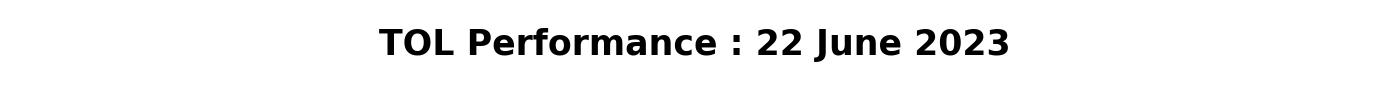

In [49]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"TOL Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

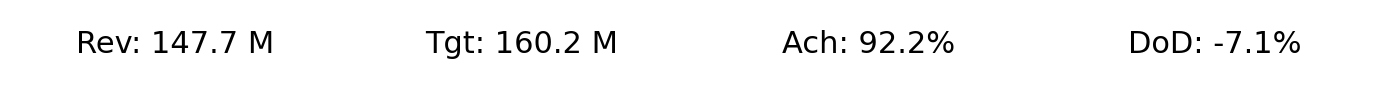

In [50]:
''' DTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

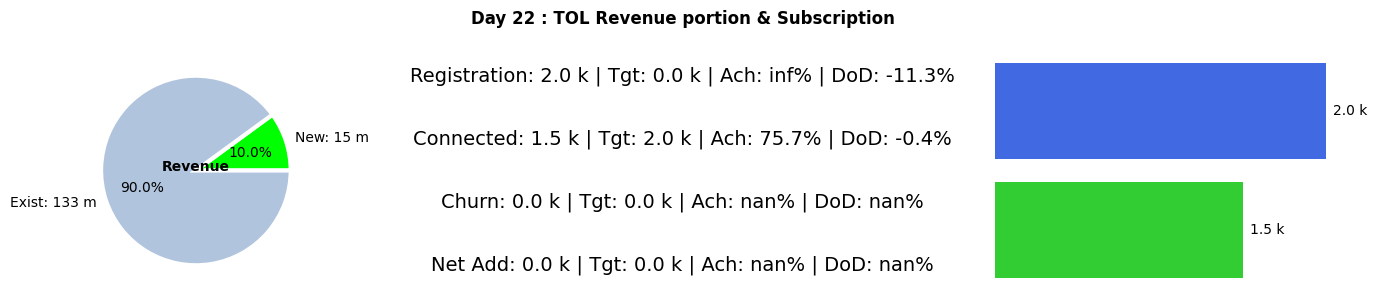

In [51]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Day {curr_day_label} : TOL Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(dtd_rev_new.sum()), unit_mb(dtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(dtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_reg_sub),',.1f')} k | Ach: {format(dtd_achv_reg_sub,',.1%')} | DoD: {format(dtd_dod_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(dtd_con_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_con_sub),',.1f')} k | Ach: {format(dtd_achv_con_sub,',.1%')} | DoD: {format(dtd_dod_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(dtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_chrn_sub),',.1f')} k | Ach: {format(dtd_achv_chrn_sub,',.1%')} | DoD: {format(dtd_dod_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(dtd_net_add),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_net_add),',.1f')} k | Ach: {format(dtd_achv_net_add,',.1%')} | DoD: {format(dtd_dod_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_dtd['METRIC_NAME'], width=unit_k(df_bar_h_dtd['VALUES']), color=df_bar_h_dtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

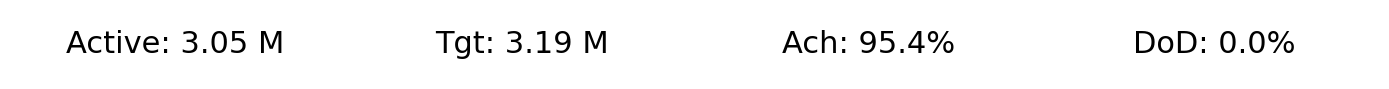

In [52]:
''' DTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(dtd_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt_actv_sub),',.2f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

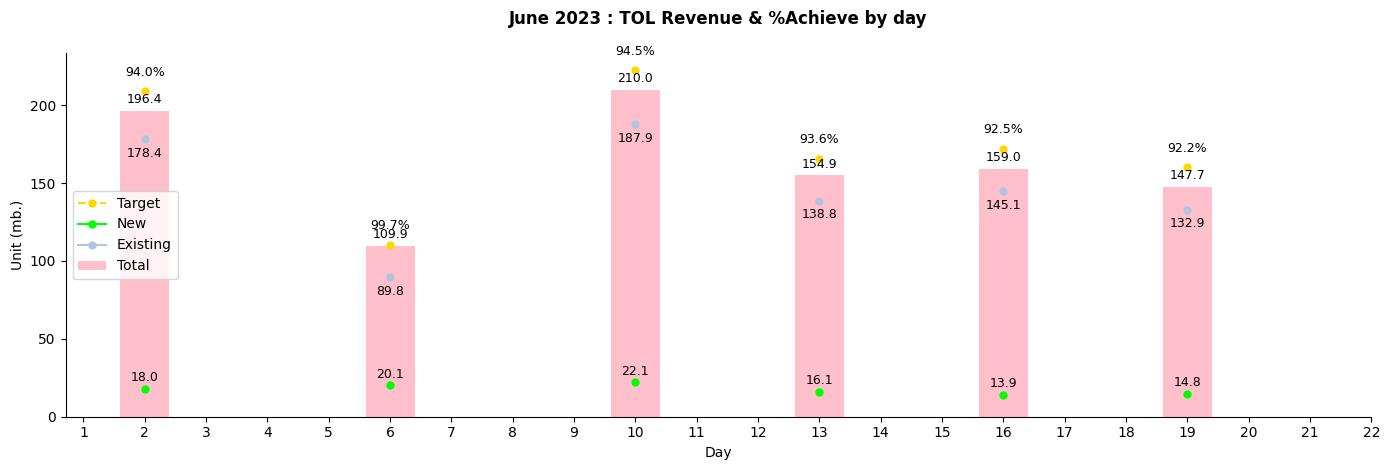

In [57]:
''' Revenue & Achieve by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : TOL Revenue & %Achieve by day\n", weight='bold')

plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')

plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_day_axis, unit_mb(y_day_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_tgt[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_new[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act_new[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_exist[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act_exist[i])-5), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

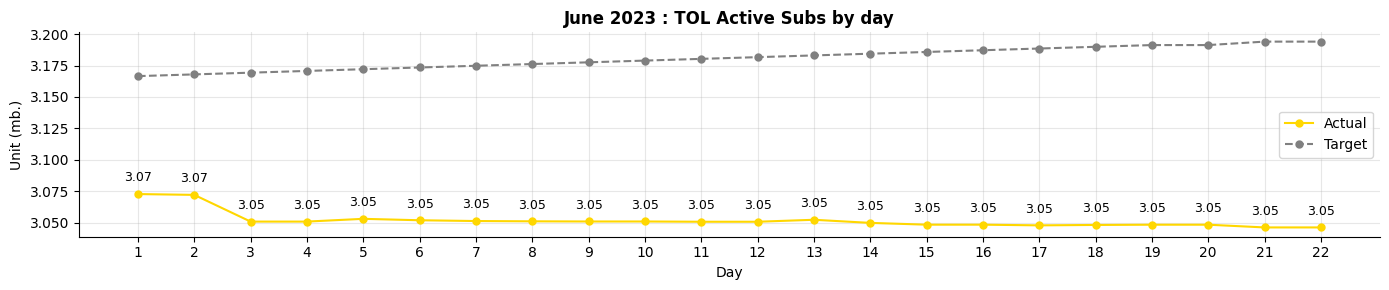

In [61]:
''' Active Subs by day '''

plt.figure(figsize=(14, 3))
plt.title(f"{curr_mth_desc} {curr_yr} : TOL Active Subs by day", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act_actv_sub[i]),',.2f'), xy=(x_day_axis[i], unit_mb(y_day_act_actv_sub[i])+0.01), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

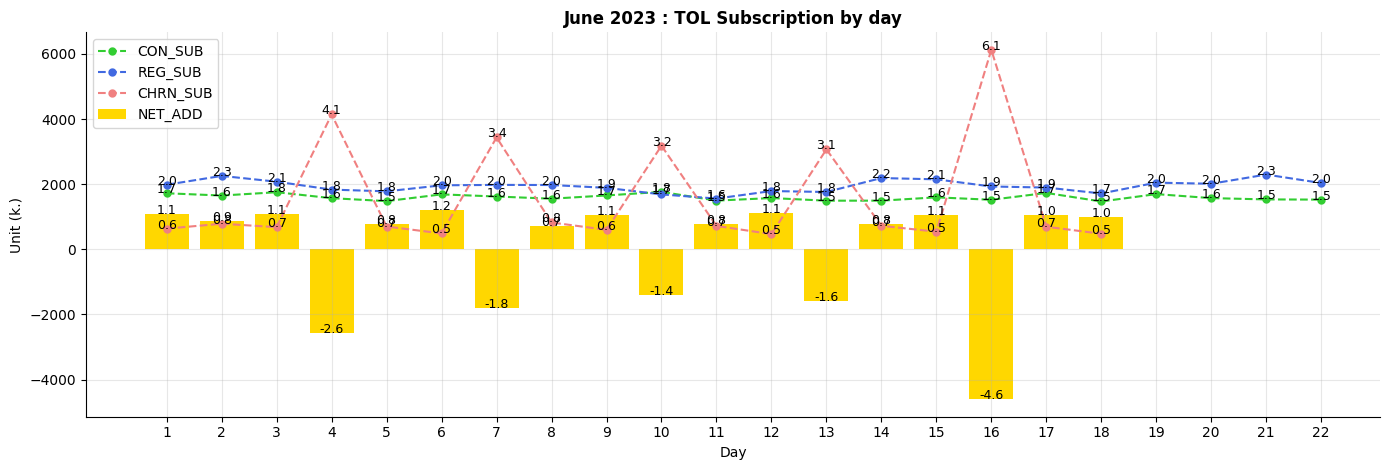

In [60]:
''' Subscription by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : TOL Subscription by day", weight='bold')

plt.plot(x_day_axis, y_day_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_day_axis, y_day_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_day_axis, y_day_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_day_axis, y_day_act_net_add, label='NET_ADD', color='gold')
for i in x_day_axis:
    plt.annotate(format(unit_k(y_day_act_con_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_con_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_reg_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_reg_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_chrn_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_chrn_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_net_add[i]),',.1f'), xy=(x_day_axis[i], y_day_act_net_add[i]), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (k.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()